In [3]:
import numpy as np
import os
import json
import torch
from torchvision import transforms
from torch.nn import functional as F
import random
import argparse
from models.vae import VAE
from models.vae_reward import VAE

from utils.misc import LSIZE, RED_SIZE

from data.loaders import RolloutObservationDataset
from data.loaders import RolloutSequenceDataset

os.environ["CUDA_VISIBLE_DEVICES"]="-1" # disable GPU

In [4]:
import matplotlib.pyplot as plt
np.set_printoptions(precision=4, edgeitems=6, linewidth=100, suppress=True)

In [7]:
### Set directory paths 
DATA_DIR = "/home/gengar888/world-models/rollouts/"
vae_dir = "/home/gengar888/world-models/exp_dir/vae"
vae_reward_dir = "/home/megumisano/world-models/exp_dir/vae_reward" 

In [10]:
### Load observation dataset (without reward)

transform_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((RED_SIZE, RED_SIZE)),
    transforms.ToTensor(),
])

dataset_test = RolloutObservationDataset(DATA_DIR,
                                         transform_test, train=False)

test_loader_no_reward = torch.utils.data.DataLoader(
    dataset_test, batch_size=32, shuffle=True, num_workers=0)

dataset_test.load_next_buffer()

Loading file buffer ...: 100%|██████████| 200/200 
Loading file buffer ...: 100%|██████████| 200/200 


In [5]:
### Load sequence datset (with reward)

SEQ_LEN = 32
BSIZE = 16

transform = transforms.Lambda(
    lambda x: np.transpose(x, (0, 3, 1, 2)) / 255)

test_loader_with_reward = torch.utils.data.DataLoader(
    RolloutSequenceDataset(DATA_DIR, SEQ_LEN, transform, train=False, buffer_size=10),
    batch_size=BSIZE, num_workers=0)

test_loader_with_reward.dataset.load_next_buffer()

Loading file buffer ...: 100%|██████████| 10/10 


In [6]:
for i, data in enumerate(test_loader_with_reward):
    obs, action, reward, terminal, next_obs = [arr for arr in data]
    if i == 0:
        print(reward)

tensor([[-0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000,
         -0.1000, -0.1000, -0.1000, -0.1000,  3.1895, -0.1000, -0.1000, -0.1000,
         -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000,
         -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000],
        [-0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000,
         -0.1000, -0.1000, -0.1000,  3.1895, -0.1000, -0.1000, -0.1000, -0.1000,
         -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000,
         -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000],
        [-0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000,
         -0.1000, -0.1000,  3.1895, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000,
         -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000,
         -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000],
        [-0.1000, -0.1000

KeyboardInterrupt: 

### Loading retrained VAE and ResNet50 

In [7]:
# Load VAE 
vae = VAE(3, LSIZE)
reload_file = os.path.join(vae_dir, 'best.tar')
state = torch.load(reload_file, map_location=lambda storage, loc: storage)
vae.load_state_dict(state['state_dict'], strict=False)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [ ]:
### print loss curves 
reload_file = os.path.join(vae_dir, 'checkpoint.tar')
state = torch.load(reload_file, map_location=lambda storage, loc: storage)
precisions = state['precision'] # which oen is it 

In [8]:
# Load VAE with reward 
vae_reward = VAE(3, LSIZE)
reload_file = os.path.join(vae_reward_dir, 'best.tar')
state = torch.load(reload_file, map_location=lambda storage, loc: storage)
vae_reward.load_state_dict(state['state_dict'], strict=False)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

### Calculate reconstruction loss on test set 

In [12]:
def loss_function(recon_x, x, mu, logsigma):
    """ VAE loss function """
    BCE = F.mse_loss(recon_x, x, size_average=False)
    KLD = -0.5 * torch.sum(1 + 2 * logsigma - mu.pow(2) - (2 * logsigma).exp())
    return BCE + KLD

def test(vae, is_standard):
    vae.eval()
    test_loss = 0
    with torch.no_grad():
        for data in test_loader_no_reward:
            if is_standard:
                recon_batch, mu, logvar = vae(data)
            else:
                recon_batch, mu, logvar, predicted_reward = vae(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
    test_loss /= len(test_loader_no_reward.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss

In [ ]:
vae_reconstruct_loss = test(vae, True)

In [13]:
vae_reward_reconstruct_loss = test(vae_reward, False)

/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


====> Test set loss: 23.8349


In [ ]:
vgg_reconstruct_loss = vgg.test()

### Qualitative analysis: reconstructing frames

In [43]:
def compare_reconstructed_frame(vae, test_loader, index):
    count = 0
    with torch.no_grad():
        for x in test_loader:
            count += 1 
            if count < 6:
                if count == 5:
                    print(x.shape)
                    recon_batch, mu, logvar, predicted_reward = vae(x)
                    original = x[index] 
                    reconstruct = recon_batch[index] 

                    original = original.numpy().transpose(1, 2, 0)
                    reconstruct = reconstruct.numpy().transpose(1,2,0)

                    fig, ax = plt.subplots(1,2)
                    ax[0].imshow(original)
                    ax[1].imshow(reconstruct)
                    plt.show()
            else:
                break

In [20]:
compare_reconstructed_frame(vae, test_loader)

NameError: name 'vae' is not defined

torch.Size([32, 3, 64, 64])


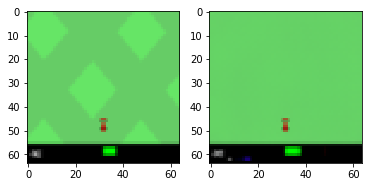

In [38]:
compare_reconstructed_frame(vae_reward, test_loader_no_reward, 0)

torch.Size([32, 3, 64, 64])


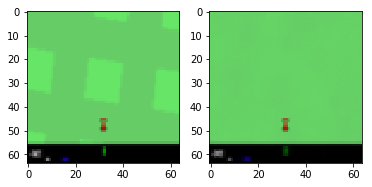

In [42]:
compare_reconstructed_frame(vae_reward, test_loader_no_reward, 5)

torch.Size([32, 3, 64, 64])


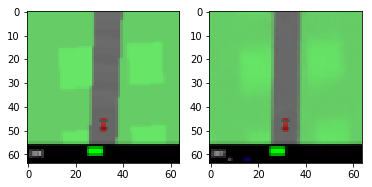

In [47]:
compare_reconstructed_frame(vae_reward, test_loader_no_reward, 5)